In [1]:
import joblib
import sys
sys.path.insert(0,'/Users/walfits/Repositories/Aglaia/')
import energies_NN as nn
import numpy as np
from sklearn import model_selection as modsel

In [2]:
# Loading the data
data = joblib.load("cc_demeaned_kjmol.bz")
X = data["X"]
y = np.reshape(data["y"], (data["y"].shape[0],))
# mean_y = np.mean(y)
# std_y = np.std(y)
# y = (y - mean_y)/std_y
print(X.shape, y.shape)

(20698, 28) (20698,)


In [3]:
# Splitting the data
X_train, X_test, y_train, y_test = modsel.train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)

(16558, 28)


In [4]:
# Training the model
estimator = nn.Energies_NN(max_iter=4000, learning_rate_init=0.005, hidden_layer_sizes=(13,), batch_size=1000,
                              alpha=0.0005, tensorboard=False)

In [5]:
estimator.fit(X_train, y_train)

In [6]:
print(estimator.all_weights[1])

[[-121.2164917    12.36386108    9.54018307   13.33166122   28.64595413
    16.4929657    24.6961689  -108.79246521   23.87962532   18.75464249
   -17.86070251    6.13975906   11.53445244]]


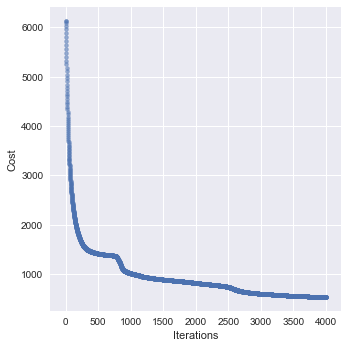

In [7]:
estimator.plot_cost()

In [8]:
estimator.scoreFull(X_test, y_test)

(0.91292966440457834,
 23.196289150915263,
 17.518049515436328,
 102.37369335629046,
 148.7658810702851)

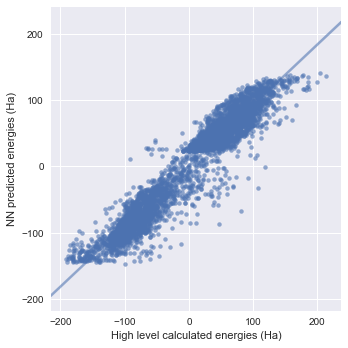

In [9]:
estimator.correlationPlot(X_test, y_test)

In [10]:
np.random.seed(seed=1)
random_input = abs(np.random.rand(28))
print(random_input.shape)

(28,)


/Users/walfits/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


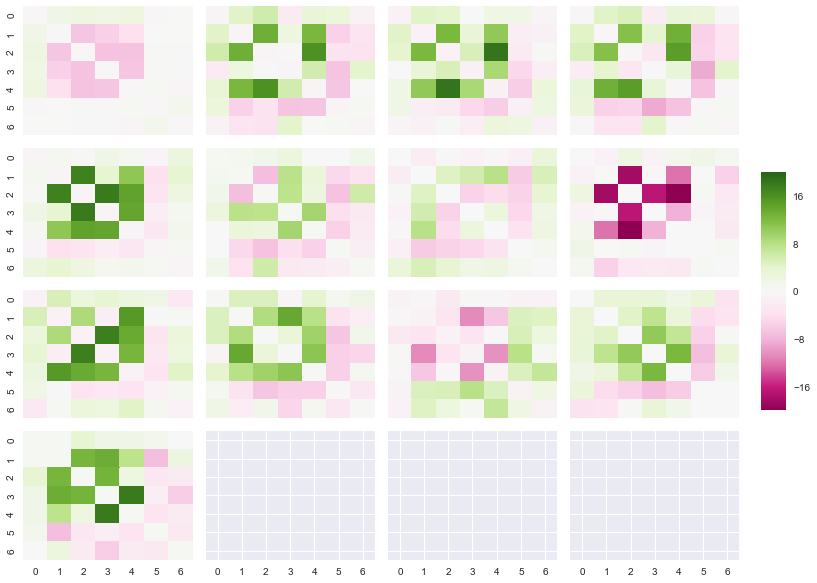

In [11]:
estimator.plotWeights()

In [ ]:
# estimator.isVisReady = False
# estimator.vis_input_matrix(random_input, alpha_l1=0.0001, alpha_l2=0.0, clipping=0.0, write_plot=False)

The activations at the end of the optimisations are:
[array([[ 0.99993575]], dtype=float32), array([[ 0.99999332]], dtype=float32), array([[ 0.99999499]], dtype=float32), array([[ 0.99999344]], dtype=float32), array([[ 0.99999404]], dtype=float32), array([[ 0.99999666]], dtype=float32), array([[ 0.99999201]], dtype=float32), array([[ 0.99990976]], dtype=float32), array([[ 0.99999404]], dtype=float32), array([[ 0.99999225]], dtype=float32), array([[ 0.99998713]], dtype=float32), array([[ 0.99999189]], dtype=float32), array([[ 0.99999452]], dtype=float32)]


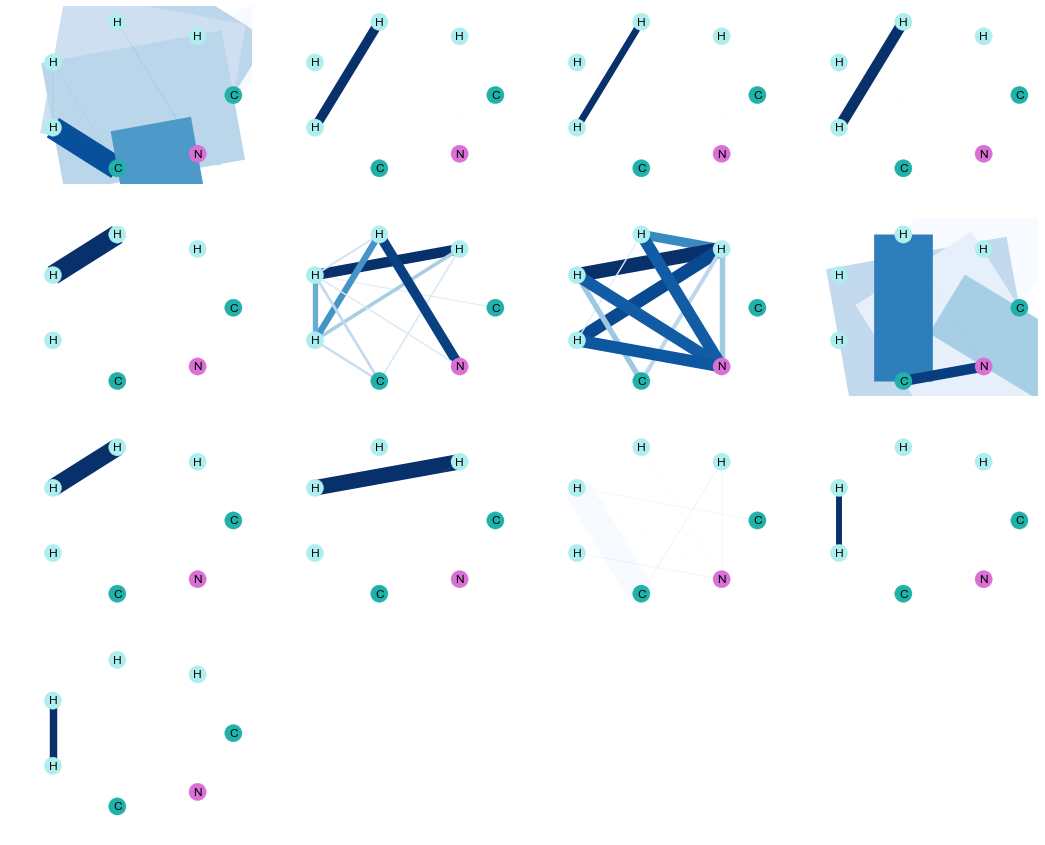

In [21]:
estimator.isVisReady = False
estimator.vis_input_network(random_input, alpha_l1=0.0001, alpha_l2=0.0, clipping=0.0, write_plot=False)

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

matrix = estimator.x_square_tot

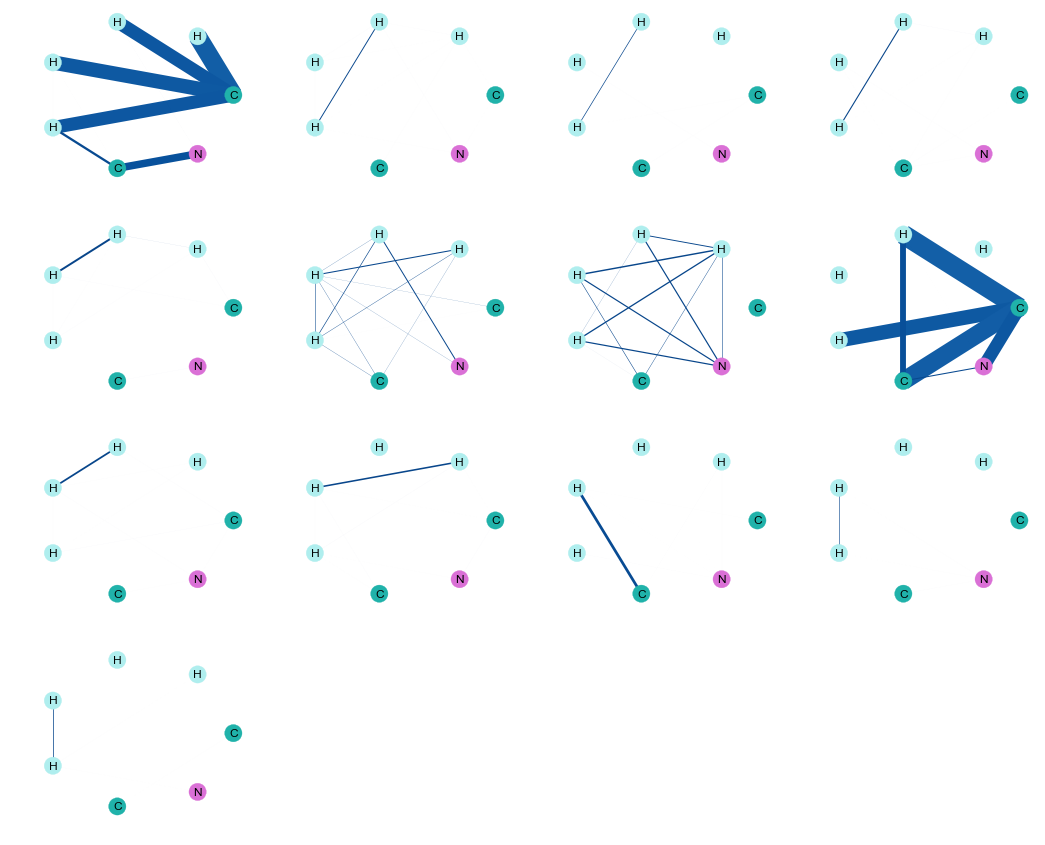

In [27]:
# for i in range(len(estimator.x_square_tot)):
#     matrix[i] = estimator.x_square_tot[i] * estimator.all_weights[1][0][i] * 0.001

# for i in range(len(estimator.x_square_tot)):
#     matrix[i] = matrix[i] * 0.1

max_val = np.amax(matrix)
min_val = np.amin(matrix)

n = int(np.ceil(np.sqrt(estimator.hidden_layer_sizes)))

fig = plt.figure(figsize=(18, 15))
for i in range(n**2):
    if i >= estimator.hidden_layer_sizes[0]:
        break
    fig.add_subplot(n,n,1+i)
    A = np.matrix(matrix[i])
    graph2 = nx.from_numpy_matrix(A, parallel_edges=False)

    labels = {}
    labels[0] = 'C'
    labels[1] = 'H'
    labels[2] = 'H'
    labels[3] = 'H'
    labels[4] = 'H'
    labels[5] = 'C'
    labels[6] = 'N'

    colors = ["lightseagreen", "paleturquoise", "paleturquoise", "paleturquoise", "paleturquoise", "lightseagreen", "orchid"]


    # edges widths
    edgewidth = [d['weight']*0.1 for (u, v, d) in graph2.edges(data=True)]

    plt.axis('off')
    nx.draw_circular(graph2,
                     width=edgewidth,
                     with_labels=True, labels=labels, node_color=colors,
                     edge_color=edgewidth, 
                     edge_cmap=plt.cm.Blues,
                     edge_vmin=min_val,
                     edge_vmax=max_val
                     )

plt.savefig("mod1tot_noweight.png", dpi=200)  # save as png

plt.show()  # display

In [26]:
plt.savefig("mod1tot_noweight.png", dpi=200)  # save as png